In [1]:
import pandas as pd
import numpy as np
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sklearn.model_selection import GridSearchCV
from sklearn import datasets, ensemble
from tqdm import tqdm

In [2]:
train_df = pd.read_csv("train_lt.csv")
sample = pd.read_csv("sample_lt.csv")

In [3]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['years'] = train_df['date'].dt.year
train_df['months'] = train_df['date'].dt.month
train_df['days'] = train_df['date'].dt.day
train_df['week_number'] = train_df['date'].dt.isocalendar().week

In [4]:
train_df.head()

,id,product_rk,store_location_rk,date,demand,PRODUCT_RK,STORE_LOCATION_RK,PRODUCT_RK_y,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,years,months,days,week_number
0,0,22939,425,2019-12-30,NaN,22939,425,22939,0,0,3649.0,2736.75,0,0,2019,12,30,1
1,1,22939,525,2019-12-30,NaN,22939,525,22939,0,0,3649.0,2371.85,0,1,2019,12,30,1
2,2,22939,557,2019-12-30,NaN,22939,557,22939,0,0,3649.0,2736.75,0,1,2019,12,30,1
3,3,22939,562,2019-12-30,NaN,22939,562,22939,0,0,3649.0,2736.75,0,0,2019,12,30,1
4,4,22939,637,2019-12-30,NaN,22939,637,22939,0,0,3649.0,3101.65,0,0,2019,12,30,1


Text(0, 0.5, 'demand')

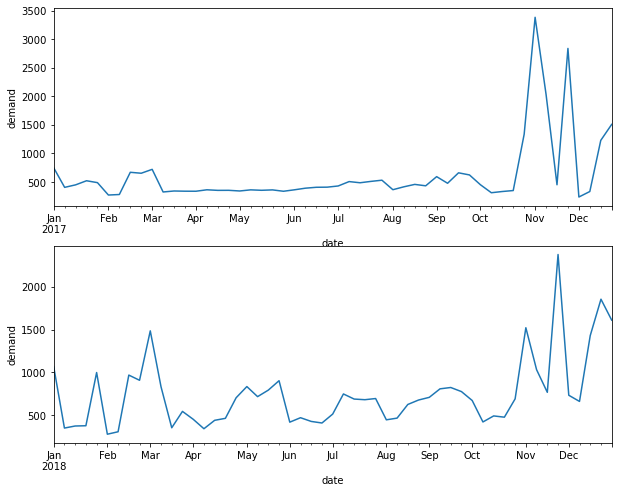

In [135]:
import matplotlib.pyplot as plt
fig, (ax0,ax1) = plt.subplots(nrows=2, ncols=1)

df_2017 = train_df[train_df['years']==2017]
df_2018 = train_df[train_df['years']==2018]

d_2017 = df_2017.groupby('date').demand.sum()
d_2018 = df_2018.groupby('date').demand.sum()

gr1 = d_2017.plot(figsize=(10,8),ax=ax0)
gr2 = d_2018.plot(figsize=(10,8),ax=ax1)

gr1.set_ylabel('demand')
gr2.set_ylabel('demand')

## Special Dates

In [4]:
def special_dates(df):
    
    d = {'NewYear':[],
         'is_feb14':[],
         'is_march8':[],
         'is_september1':[],
         'is_blackFR':[]}
    
    for i in tqdm(range(0, len(df))):
        row = train_df[df["id"] == i]
        #NewYear
        if (row['week_number'].values[0] == 52) or (row['week_number'].values[0] == 51):
            d['NewYear'].append(1)
        else:
            d['NewYear'].append(0)
            
        #is_feb14
        if (row['years'].values[0] == 2016 and row['week_number'].values[0] == 6):
            d['is_feb14'].append(1)
        elif (row['years'].values[0] == 2017 and (row['week_number'].values[0] == 6 or row['week_number'].values[0] == 7)):
            d['is_feb14'].append(1)
        elif (row['years'].values[0] == 2018 and (row['week_number'].values[0] == 6 or row['week_number'].values[0] == 7)):
            d['is_feb14'].append(1)
        elif (row['years'].values[0] == 2019 and row['week_number'].values[0] == 7):
            d['is_feb14'].append(1)
        else:
            d['is_feb14'].append(0)
            
        #is_march
        if (row['week_number'].values[0] == 9) or (row['week_number'].values[0] == 10):
            d['is_march8'].append(1)
        else:
            d['is_march8'].append(0)
        
        #is_september1
        if row['week_number'].values[0] == 35:
            d['is_september1'].append(1)
        else:
            d['is_september1'].append(0)
        
        #is_blackFR
        if (row['years'].values[0] == 2016 and row['week_number'].values[0] == 47):
            d['is_blackFR'].append(1)
        elif (row['years'].values[0] == 2017 and row['week_number'].values[0] == 47):
            d['is_blackFR'].append(1)
        elif (row['years'].values[0] == 2018 and row['week_number'].values[0] == 47):
            d['is_blackFR'].append(1)
        elif (row['years'].values[0] == 2019 and row['week_number'].values[0] == 48):
            d['is_blackFR'].append(1)
        else:
            d['is_blackFR'].append(0)
                        
    return d

In [5]:
# ny = is_newyear(train_df)
# feb14 = is_feb14(train_df)
# march8 = is_march8(train_df)
# spt = is_september1(train_df)
# b_fr = is_blackFR(train_df)
sp_dates = special_dates(train_df)

train_df["NY"] = sp_dates["NewYear"]
train_df["F14"] = sp_dates["is_feb14"]
train_df["Mar8"] = sp_dates["is_march8"]
train_df["Spt1"] = sp_dates["is_september1"]
train_df["b_FR"] = sp_dates["is_blackFR"]

100%|██████████| 282322/282322 [13:17<00:00, 353.89it/s]


In [6]:
t = train_df.dropna(subset=['demand'])
t = t.drop(columns=['PRODUCT_RK_y','PRODUCT_RK','store_location_rk'])
t = t.fillna(method='ffill')
t = t.sort_values(by='date')

In [7]:
new_prod = train_df[train_df['demand'].isnull()]
new_prod = new_prod.drop(columns=['demand'])
new_prod = new_prod.sort_values(by='date')
new_prod = new_prod.fillna(method='ffill')
new_prod_nolags = new_prod[new_prod['id'].isin(sample['index'])]
new_prod_nolags = new_prod_nolags.drop(columns=['store_location_rk','PRODUCT_RK','PRODUCT_RK_y'])

## Two-stage forecasting

In [25]:
arr = t.groupby('date').demand.mean()
arr.describe()
# t['demand_by_date'].describe()

count    106.000000
mean       0.428515
std        0.295090
min        0.124945
25%        0.233460
50%        0.340990
75%        0.470604
max        1.511504
Name: demand, dtype: float64

In [28]:
demand_by_date = pd.DataFrame(arr)
demand_by_date = demand_by_date.reset_index()
new_col = []
for i in tqdm(range(len(t))):
    date = t.iloc[i]['date']
    new_col.append(demand_by_date[demand_by_date['date']==date]['demand'].tolist()[0])

100%|██████████| 178995/178995 [04:21<00:00, 683.89it/s]


In [29]:
t['demand_by_date'] = new_col
check = t.demand_by_date > 0.55
t['big_demand'] = check.tolist()
t['big_demand'] = t['big_demand'].astype(int)

#### First-stage

In [30]:
from sklearn.model_selection import train_test_split
# t_nolags = t.drop(columns=['lag_store_52','lag_store_53','lag_store_54','lag_prod_52','lag_prod_53'])
t2 = t.dropna()
new_prod2 = new_prod2.fillna(0)
X_first = t2.drop(columns=['demand','id','date','demand_by_date','big_demand'])
y_first = t2['big_demand']
X_train, X_test, y_train, y_test = train_test_split(X_first, y_first, test_size=0.33, random_state=42,shuffle=False)

In [31]:
from sklearn import datasets, ensemble
# define the model parameters
params = {'n_estimators': 500,
          'max_depth': 7,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'deviance'}
model = ensemble.GradientBoostingClassifier(**params)
model.fit(X_first, y_first)

GradientBoostingClassifier(learning_rate=0.01, max_depth=7, n_estimators=500)

In [ ]:
# #Hyperparameter tuning and fitting of gradient boosting
# regr = GridSearchCV(ensemble.GradientBoostingClassifier(),
#                      {
#                          'n_estimators':[450,500,600],
#                          'max_depth':np.arange(5,7), 
#                          'min_samples_split':[2,5],
#                          'learning_rate':[0.01]
#                      }, cv=5,n_jobs=-1,scoring="neg_mean_absolute_percentage_error"
# )
# regr.fit(X,y)
# print('Best training score:', regr.best_score_)
# print('Best estimators:', regr.best_estimator_)
# best_regr = regr.best_estimator_
# # print("Gradient Boosting test f1 score: ",f1_score(y_test,best_svc.predict(X_test)))

In [62]:



if_high_sales = (X_res.months == 11) | (X_res.months == 12) | (X_res.months == 3)
if_high_sales = if_high_sales.tolist()
for i in range(len(if_high_sales)):
    if if_high_sales[i] == True:
        fs_res[i] = 1
    if (X_res['NY'].iloc[i] == 1) | (X_res['F14'].iloc[i] == 1) | (X_res['Mar8'].iloc[i] == 1) | (X_res['Spt1'].iloc[i] == 1) | (X_res['b_FR'].iloc[i] == 1):
        fs_res[i] = 1
    


In [33]:
X_res = new_prod2.drop(columns=['id','date'])
fs_res = model.predict(X_res)
X_res['big_demand'] = fs_res
big = X_res[X_res['big_demand']==1]
small = X_res[X_res['big_demand']==0]

#### Second-stage

In [35]:
t_big = t2[t2['big_demand']==1]
X_big = t_big.drop(columns=['demand','id','date','demand_by_date','big_demand'])
y_big = t_big['demand']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_big, y_big, test_size=0.33, random_state=42,shuffle=False)

In [39]:
from sklearn import datasets, ensemble
# define the model parameters
params = {'n_estimators': 500,
          'max_depth': 5,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'lad'}
regr_big = ensemble.GradientBoostingRegressor(**params)
regr_big.fit(X_big, y_big)

GradientBoostingRegressor(learning_rate=0.01, loss='lad', max_depth=5,
                          n_estimators=500)

In [38]:
smape_loss = MeanAbsolutePercentageError()
y_pred = regr_big.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i] <0:
        y_pred[i] = 0
y_test = y_test.reset_index()
y_test = y_test.drop(columns=['index'])
y_test = y_test['demand']
y_pred = pd.Series(y_pred)
smape_loss(y_pred, y_test)

0.6511277440809008

In [35]:
# #Hyperparameter tuning and fitting of gradient boosting
# regr_big = GridSearchCV(ensemble.GradientBoostingRegressor(),
#                      {
#                          'n_estimators':[500,600],
#                          'max_depth':np.arange(5,7), 
#                          'min_samples_split':[2,5],
#                          'learning_rate':[0.01]
#                      }, cv=5,n_jobs=-1,scoring="neg_mean_absolute_percentage_error"
# )
# regr_big.fit(X_big,y_big)
# print('Best training score:', regr_big.best_score_)
# print('Best estimators:', regr_big.best_estimator_)

# # print("Gradient Boosting test f1 score: ",f1_score(y_test,best_svc.predict(X_test)))

In [205]:
best_regr_big = regr_big.best_estimator_

In [40]:
big = big.drop(columns=['big_demand'])
pred_big = regr_big.predict(big)
for i in range(len(pred_big)):
    if pred_big[i] <0:
        pred_big[i] = 0
big['pred'] = pred_big

In [229]:
#assign fixed value to small demands
const = 0.1
pred_sm = [const]*len(small)
small['pred'] = pred_sm

In [41]:
#or Regress the small demands
t_small = t2[t2['big_demand']==0]
X_small = t_small.drop(columns=['demand','id','date','demand_by_date','big_demand'])
y_small = t_small['demand']

params = {'n_estimators': 500,
          'max_depth': 5,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'lad'}
regr_small = ensemble.GradientBoostingRegressor(**params)
regr_small.fit(X_small, y_small)

GradientBoostingRegressor(learning_rate=0.01, loss='lad', max_depth=5,
                          n_estimators=500)

In [207]:
t_small = t_nolags[t_nolags['big_demand']==0]
X_small = t_small.drop(columns=['demand','id','date','demand_by_date','big_demand'])
y_small = t_small['demand']

regr_small = GridSearchCV(ensemble.GradientBoostingRegressor(),
                     {
                         'n_estimators':[500,600],
                         'max_depth':np.arange(5,7), 
                         'min_samples_split':[2,5],
                         'learning_rate':[0.01]
                     }, cv=5,n_jobs=-1,scoring="neg_mean_absolute_percentage_error"
)
regr_small.fit(X_small,y_small)
print('Best training score:', regr_small.best_score_)
print('Best estimators:', regr_small.best_estimator_)
best_regr_sm = regr_small.best_estimator_

Best training score: -31860477737568.05
Best estimators: GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500)


In [42]:
small = small.drop(columns=['big_demand'])
pred_sm = regr_small.predict(small)
for i in range(len(pred_sm)):
    if pred_sm[i] <0:
        pred_sm[i] = 0
small['pred'] = pred_sm

In [43]:
final_new = pd.concat([small,big])
final_new = final_new.reset_index()
# final_new[final_new['index']==183536]['pred']

not_2019 = set(sample[~sample['index'].isin(final_new['index'])]['index'])

d = dict()
keys = list(sample['index'])
for i in tqdm(keys):
    if i in not_2019:
        d[i] = list(train_df[train_df['id']==i]['demand'])
    else:
        d[i] = list(final_new[final_new['index']==i]['pred'])


100%|██████████| 26605/26605 [00:23<00:00, 1123.46it/s]


In [44]:
sam_res = pd.DataFrame.from_dict(d, orient='index')
# sam_res = sam_res.reset_index()
sam_res.index.name = 'index'
sam_res['demand'] = sam_res[0]
sam_res = sam_res.drop(columns=[0])
sam_res.to_csv('predicted_demand.csv')
sam_res

,demand
index,
9,0.869903
148,0.972586
214,0.215491
10,0.023217
13,0.330574
...,...
282317,1.000219
282318,1.001266
282319,1.321746


## Lagged features

In [17]:
def store_lag(df):
    d = {'lag_store_52':[],
         'lag_store_53':[],
         'lag_store_54':[]}
#         'lag_store_55':[],
#         'lag_store_56':[],
#         'lag_store_57':[],
#         'lag_store_58':[],
#         'lag_store_59':[],
#         'lag_store_60':[]}

    keys = list(d.keys())
    for index, row in tqdm(df.iterrows()): #take a row
        store_df = t[t['STORE_LOCATION_RK']==row['STORE_LOCATION_RK']] #take all rows in train with the same store id
        
        for i in range(3):
            week_num = row['week_number']-2 #week_num = 23 2018 year 1-22 weeks + 2017 year 23-52 weeks
            year = row['years']-1
            if week_num <= 0:
                year -= 1 #2016
                week_num = 52+week_num 
            
            sub1 = store_df[(store_df['years'] > year) & (store_df['week_number'] < row['week_number'])]
            sub2 = store_df[(store_df['years'] == year) & (store_df['week_number'] >=week_num)]
            all_needed = pd.concat([sub1,sub2]).groupby('date').demand.mean() #for each day in this sub dataframe, calculate demand mean
            d[keys[i]].append(all_needed.mean())
#             subset = store_df[(store_df['years']==year) & (store_df['week_number']==week_num)]
#             d[keys[i]].append(subset['demand'].mean())
    return d
#         product_df = 


# 2018.09.01 store=200

In [57]:
def prod_lag(df):
    d = {'lag_prod_52':[],
        'lag_prod_53':[]}
#         'lag_prod_54':[]}
#         'lag_prod_55':[],
#         'lag_prod_56':[],
#         'lag_prod_57':[],
#         'lag_prod_58':[],
#         'lag_prod_59':[],
#         'lag_prod_60':[]}

    keys = list(d.keys())
    for index, row in tqdm(df.iterrows()):
        prod_df = t[t['product_rk']==row['product_rk']]
        
        for i in range(2):
            week_num = row['week_number']-i
            year = row['years']-1
            if week_num <= 0:
                year -= 1
                week_num = 52+week_num
                
#             p_idx = prod_df.years > year
#             sub1 = prod_df[p_idx]
            sub1 = prod_df[(prod_df['years'] > year) & (prod_df['week_number'] < row['week_number'])]
            sub2 = prod_df[(prod_df['years'] == year) & (prod_df['week_number'] >=week_num)]
            all_needed = pd.concat([sub1,sub2]).groupby('date').demand.mean()
            d[keys[i]].append(all_needed.mean())
            
#             subset = prod_df[(prod_df['years']==year) & (prod_df['week_number']==week_num)]
#             d[keys[i]].append(subset['demand'].mean())
    return d
#         product_df = 

In [18]:
d_new_prod = store_lag(new_prod_nolags)

25824it [16:12, 26.56it/s]


In [19]:
d_t = store_lag(t)

178995it [2:04:36, 23.94it/s]


In [20]:
new_prod2 = new_prod_nolags
for key in d_t:
    t[key] = d_t[key]
    new_prod2[key] = d_new_prod[key]

In [114]:
t2['lag_store_52'] = t['lag_store_52']
t2['lag_store_53'] = t['lag_store_53']
t2['lag_store_54'] = t['lag_store_54']

In [58]:
p_t = prod_lag(t)
p_new_prod = prod_lag(new_prod2)

178995it [36:06, 82.63it/s]
25824it [04:51, 88.70it/s]


In [59]:
for key in p_t:
    t[key] = p_t[key]
    new_prod2[key] = p_new_prod[key]

In [115]:
# t2 = t.fillna(0)
t2 = t2.dropna()
new_prod2 = new_prod2.fillna(0)

## Original

In [80]:
t2 = t

In [118]:
from sklearn.model_selection import train_test_split
X = t2.drop(columns=['demand','id','date'])
y = t2['demand']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=False)

In [128]:
X

,product_rk,STORE_LOCATION_RK,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,years,months,days,week_number,NY,F14,Mar8,Spt1,b_FR,lag_store_54,lag_store_52,lag_store_53
51670,37553,1005,1,1,3499.000000,1749.500000,0,1,2016,12,26,52,1,0,0,0,0,0.369063,0.369063,0.369063
249270,34978,1281,1,0,3349.000000,1674.500000,0,1,2016,12,26,52,1,0,0,0,0,0.678936,0.678936,0.678936
249254,34978,1203,1,0,3134.714286,1567.357143,0,1,2016,12,26,52,1,0,0,0,0,0.312705,0.312705,0.312705
249237,34978,1191,1,0,3427.571429,2144.371429,0,1,2016,12,26,52,1,0,0,0,0,0.276173,0.276173,0.276173
249162,34978,866,1,0,3349.000000,1674.500000,0,1,2016,12,26,52,1,0,0,0,0,0.353527,0.353527,0.353527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37754,32814,874,1,0,3600.000000,2700.000000,0,1,2018,12,31,1,0,0,0,0,0,0.869504,0.293320,0.869504
3447,22962,657,0,0,3849.000000,2501.850000,0,1,2018,12,31,1,0,0,0,0,0,1.051911,0.310380,1.051911
103559,74769,535,1,0,3750.000000,2410.714286,0,1,2018,12,31,1,0,0,0,0,0,0.765008,0.243534,0.765008
274734,89585,1191,0,0,4449.000000,4004.100000,0,1,2018,12,31,1,0,0,0,0,0,1.086851,0.245080,1.086851


In [122]:
params = {'n_estimators': 500,
          'max_depth': 7,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'ls'}
regr = ensemble.GradientBoostingRegressor(**params)
regr.fit(X,y)

GradientBoostingRegressor(learning_rate=0.01, max_depth=7, n_estimators=500)

In [45]:
#Hyperparameter tuning and fitting of gradient boosting
# regr = GridSearchCV(ensemble.GradientBoostingRegressor(),
#                      {
#                          'n_estimators':[450,500,600],
#                          'max_depth':np.arange(5,7), 
#                          'min_samples_split':[2,5],
#                          'learning_rate':[0.01]
#                      }, cv=5,n_jobs=-1,scoring="neg_mean_absolute_percentage_error"
# )
# regr.fit(X,y)
# print('Best training score:', regr.best_score_)
# print('Best estimators:', regr.best_estimator_)
# best_regr = regr.best_estimator_
# print("Gradient Boosting test f1 score: ",f1_score(y_test,best_svc.predict(X_test)))

In [ ]:
# pred = model.predict(X_test)
# res = pred == y_test
# res.astype(int).sum()/len(res)

In [121]:
# from sktime.performance_metrics.forecasting import smape_loss
smape_loss = MeanAbsolutePercentageError()
y_pred = regr.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i] <0:
        y_pred[i] = 0
y_test = y_test.reset_index()
y_test = y_test.drop(columns=['index'])
y_test = y_test['demand']
y_pred = pd.Series(y_pred)
smape_loss(y_pred, y_test)

0.9915737697284737

In [123]:
X_res = new_prod2.drop(columns=['id','date'])
# kaggle_pred = regr.predict(X_res)
kaggle_pred = regr.predict(X_res)
for i in range(len(kaggle_pred)):
    if kaggle_pred[i] <0:
        kaggle_pred[i] = 0

In [124]:
id = new_prod2['id'].tolist()
dic = {'id':id,'predicted':kaggle_pred}
res = pd.DataFrame(dic)
res
# res.set_index("id", inplace=True)

,id,predicted
0,183536,0.408933
1,234107,0.668460
2,61585,0.263341
3,150642,0.287279
4,95769,0.634314
...,...,...
25819,176213,0.601820
25820,128833,0.241208
25821,176186,1.595684
25822,128841,0.242535


In [125]:
r = res[res['id'].isin(sample['index'])]
r
# r[r['id']==9]

,id,predicted
0,183536,0.408933
1,234107,0.668460
2,61585,0.263341
3,150642,0.287279
4,95769,0.634314
...,...,...
25819,176213,0.601820
25820,128833,0.241208
25821,176186,1.595684
25822,128841,0.242535


In [126]:
from tqdm import tqdm
not_2019 = set(sample[~sample['index'].isin(res['id'])]['index'])

d = dict()
keys = list(sample['index'])
for i in tqdm(keys):
    if i in not_2019:
        d[i] = list(train_df[train_df['id']==i]['demand'])
    else:
        d[i] = list(r[r['id']==i]['predicted'])


100%|██████████| 26605/26605 [00:20<00:00, 1325.21it/s]


In [127]:
sam_res = pd.DataFrame.from_dict(d, orient='index')
# sam_res = sam_res.reset_index()
sam_res.index.name = 'index'
sam_res['demand'] = sam_res[0]
sam_res = sam_res.drop(columns=[0])
sam_res.to_csv('predicted_demand.csv')
sam_res

,demand
index,
9,0.779222
148,0.649584
214,0.470698
10,0.387877
13,0.839962
...,...
282317,1.533267
282318,1.590723
282319,3.730623
